In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

from utils import display, sample_batch

2024-03-15 18:48:46.745980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 18:48:46.746005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 18:48:46.746643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 0. Parameters

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

# 1. Prepare the data

In [ ]:
!kaggle datasets download jessicali9530/celeba-dataset

In [ ]:
!unzip celeba-dataset.zip -d ./data
!rm "celeba-dataset.zip"

In [4]:
# Load the label dataset
attributes = pd.read_csv("./data/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
# Load the data
labels = attributes[LABEL].tolist()
int_labels = [x if x == 1 else 0 for x in labels]

In [6]:
train_data = utils.image_dataset_from_directory(
    "./data/img_align_celeba",
    labels=int_labels,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 2 classes.


2024-03-15 18:48:58.871627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 18:48:58.880096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 18:48:58.883701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(
    lambda x, y: (preprocess(x), tf.one_hot(y, depth=CLASSES))
)

In [8]:
# Show some faces from the training set
train_sample = sample_batch(train)

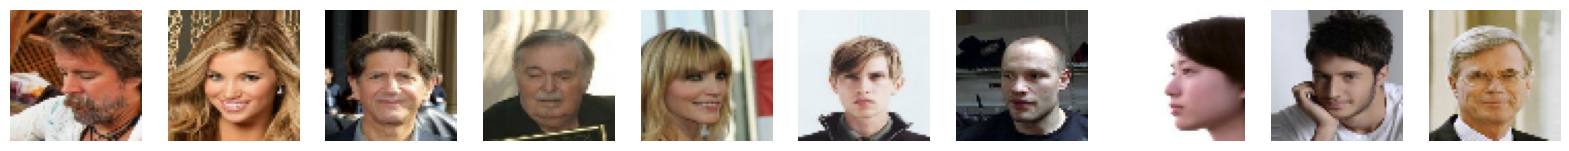

In [9]:
display(train_sample, cmap=None)

# 2. Build the GAN

In [10]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CLASSES))
x = layers.Concatenate(axis=-1)([critic_input, label_input])
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input, label_input], critic_output)
critic.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64, 64, 2)]          0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 64, 64, 5)            0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           5184      ['concatenate[0][0]']     

In [11]:
generator_input = layers.Input(shape=(Z_DIM,))
label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input, label_input])
x = layers.Reshape((1, 1, Z_DIM + CLASSES))(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 34)                   0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 1, 1, 34)             0         ['concatenate_1[0][0]'] 

In [12]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(
        self, batch_size, real_images, fake_images, image_one_hot_labels
    ):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(
                [interpolated, image_one_hot_labels], training=True
            )

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                )

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                )
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            )
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [13]:
# Create a GAN
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [14]:
if LOAD_MODEL:
    cgan.load_weights("./checkpoint/checkpoint.ckpt")

# 3. Train the GAN

In [15]:
# Compile the GAN
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [16]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        # 0 label
        zero_label = np.repeat([[1, 0]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, zero_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_0.png" % (epoch),
            cmap=None,
        )

        # 1 label
        one_label = np.repeat([[0, 1]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, one_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_1.png" % (epoch),
            cmap=None,
        )

In [ ]:
history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [18]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


# 4. Generate images

1/1 [==============================] - 0s 222ms/step


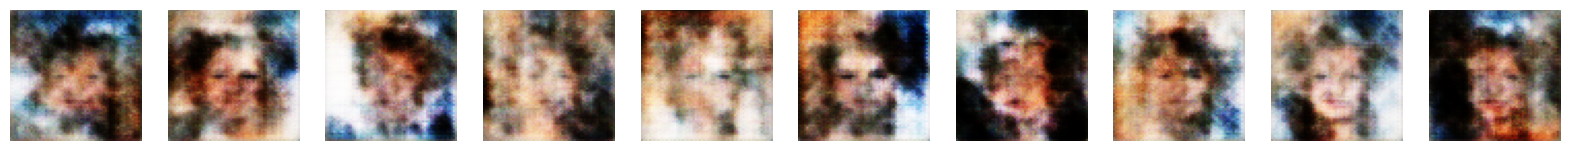

In [19]:
# 0 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[1, 0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

1/1 [==============================] - 0s 14ms/step


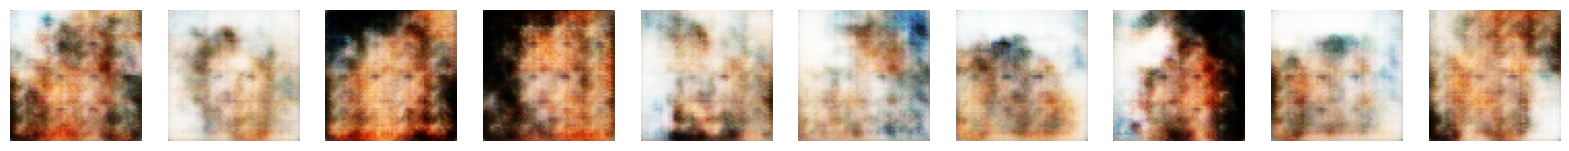

In [20]:
# 1 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[0, 1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)